In [18]:
# Part 0: Setup and Global Configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import glob
import os
import time # For timing epochs
from sklearn.metrics import accuracy_score 
# For reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- Define global constants based on recommendations ---
DATA_PATH = "data/"
SEQUENCE_LENGTH = 500
ENCODING_DIM_AE = 64

# --- Autoencoder Specific Training Parameters ---
AE_TRAIN_EPOCHS_FINAL = 150  # אפשר להתאים
AE_PATIENCE_FINAL = 20       # הורדנו מעט את הסבלנות, להתאים לפי הצורך
AE_BATCH_SIZE = 32
AE_LEARNING_RATE = 1e-3
AE_WEIGHT_DECAY = 5e-5     # העלינו מעט את ה-weight decay
AE_DROPOUT_RATE = 0.3      # העלינו מעט את ה-dropout rate
AE_INPUT_NOISE_STD = 0.05  # סטיית תקן לרעש שנוסיף לקלט ה-AE, 0 כדי לבטל
AE_PLOT_RECONSTRUCTION_EPOCHS = 25 # כל כמה אפוקים להציג גרף שחזורים

# Classifier training parameters
CLASSIFIER_TRAIN_EPOCHS = 100
CLASSIFIER_BATCH_SIZE = 32
AE_BATCH_SIZE = 32        # Adjusted for potentially larger models

# Fine-tuning stages epochs (can be adjusted)
FT_P1_EPOCHS = 200 # Head only
FT_P2_EPOCHS = 100  # Encoder FC layer + Head
FT_P3_EPOCHS = 120  # Encoder last conv block + FC + Head
FT_P4_EPOCHS = 120  # Encoder last 2 conv blocks + FC + Head
FT_P5_EPOCHS = 200 # Full encoder + Head
FT_PATIENCE = 20 # Patience for each fine-tuning phase

FT_P1_LR = 1e-4  
FT_P2_LR = 5e-6
FT_P3_LR = 1e-5
FT_P4_LR = 8e-6
FT_P5_LR = 5e-6

FT_P1_PATIENCE = 30
FT_P2_PATIENCE = 50
FT_P3_PATIENCE = 50
FT_P4_PATIENCE = 50
FT_P5_PATIENCE = 30
# --- PyTorch Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# --- Part 1: Data Loading and Preparation ---
print("--- Part 1: Data Loading and Preparation ---")
# (Assuming load_and_prepare_data and create_sequences functions are defined as in your previous code)
def load_and_prepare_data(data_path_folder):
    file_mapping = {
        'car_nothing(AVI).csv': 'quiet',
        'carnew(AVI).csv': 'vehicle',
        'human_nothing(AVI).csv': 'quiet',
        'human(AVI).csv': 'human'
    }
    label_encoding = {'quiet': 0, 'vehicle': 1, 'human': 2}
    all_data = []
    all_labels = []
    print("Starting data loading...")
    if not os.path.exists(data_path_folder):
        print(f"Data folder {data_path_folder} not found. Please create it and add data files.")
        return np.array([]), np.array([])
    for filename, activity_type in file_mapping.items():
        filepath = os.path.join(data_path_folder, filename)
        if not os.path.exists(filepath):
            print(f"Error: File not found at {filepath}. Skipping.")
            continue
        try:
            df = pd.read_csv(filepath, header=None)
            if not df.empty and df.shape[1] > 0:
                data = df.iloc[:, 0].values
                label_code = label_encoding[activity_type]
                all_data.extend(data)
                all_labels.extend([label_code] * len(data))
            else:
                print(f"Warning: File {filename} is empty or has no data columns. Skipping.")
        except Exception as e:
            print(f"Error reading {filename}: {e}")
    all_data_np = np.array(all_data)
    all_labels_np = np.array(all_labels)
    if len(all_data_np) > 0:
        print(f"Total data points loaded: {len(all_data_np)}")
    else:
        print("No data was loaded.")
    return all_data_np, all_labels_np

X_raw, y_raw = load_and_prepare_data(DATA_PATH)

if len(X_raw) == 0:
    print("No data loaded. Exiting.")
    exit()

def create_sequences(data, labels, sequence_length):
    sequences = []
    sequence_labels = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        label_data = data[label_indices]
        num_sequences_for_label = len(label_data) // sequence_length
        for i in range(num_sequences_for_label):
            start_idx = i * sequence_length
            end_idx = start_idx + sequence_length
            sequences.append(label_data[start_idx:end_idx])
            sequence_labels.append(label)
    return np.array(sequences), np.array(sequence_labels)

X_sequences, y_sequences = create_sequences(X_raw, y_raw, SEQUENCE_LENGTH)

if len(X_sequences) == 0:
    print("No sequences were created. Exiting.")
    exit()
print(f"Created {len(X_sequences)} sequences with length {SEQUENCE_LENGTH}.")

X_train_seq, X_temp_seq, y_train, y_temp = train_test_split(
    X_sequences, y_sequences, test_size=0.3, random_state=SEED, stratify=y_sequences
)
X_val_seq, X_test_seq, y_val, y_test = train_test_split(
    X_temp_seq, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

scaler = StandardScaler()
X_train_flat = X_train_seq.reshape(-1, 1); scaler.fit(X_train_flat)
X_train_normalized = scaler.transform(X_train_flat).reshape(X_train_seq.shape)
X_val_normalized = scaler.transform(X_val_seq.reshape(-1, 1)).reshape(X_val_seq.shape)
X_test_normalized = scaler.transform(X_test_seq.reshape(-1, 1)).reshape(X_test_seq.shape)

X_train_reshaped = X_train_normalized[:, np.newaxis, :]
X_val_reshaped = X_val_normalized[:, np.newaxis, :]
X_test_reshaped = X_test_normalized[:, np.newaxis, :]

X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_reshaped, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset_ae = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset_ae = TensorDataset(X_val_tensor, X_val_tensor)
train_loader_ae = DataLoader(train_dataset_ae, batch_size=AE_BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader_ae = DataLoader(val_dataset_ae, batch_size=AE_BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

train_dataset_clf = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_clf = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_clf = TensorDataset(X_test_tensor, y_test_tensor)
train_loader_clf = DataLoader(train_dataset_clf, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader_clf = DataLoader(val_dataset_clf, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader_clf = DataLoader(test_dataset_clf, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"DataLoaders created. Train AE: {len(train_loader_ae)} batches, Train CLF: {len(train_loader_clf)} batches.")


--- Part 1: Data Loading and Preparation ---
Starting data loading...
Total data points loaded: 3367075
Created 6733 sequences with length 500.
DataLoaders created. Train AE: 148 batches, Train CLF: 295 batches.



--- Part 3: Dilated Convolutional Autoencoder (Type A) - Enhanced Training ---


c:\Users\lidor\Desktop\פרויקט גיבוי\ProjectV4\torch_env_venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Starting Autoencoder (Type A) training with parameters:
  Epochs: 150, Patience: 20
  Batch Size: 32, LR: 1.0e-03, Weight Decay: 5.0e-05
  Dropout Rate: 0.3, Input Noise STD: 0.05, Encoding Dim: 64
AE Epoch 1/150 - 7.08s - Train Loss: 2.540962 - Val Loss: 0.652344 (Best: inf) - LR: 1.0e-03
  Val Loss improved from inf to 0.652344. Saving model.
AE Epoch 5/150 - 6.12s - Train Loss: 0.308094 - Val Loss: 0.203619 (Best: 0.247911) - LR: 1.0e-03
  Val Loss improved from 0.247911 to 0.203619. Saving model.
  Val Loss improved from 0.089620 to 0.056918. Saving model.
AE Epoch 10/150 - 6.12s - Train Loss: 0.128603 - Val Loss: 0.038698 (Best: 0.056918) - LR: 1.0e-03
  Val Loss improved from 0.056918 to 0.038698. Saving model.
  Val Loss improved from 0.038698 to 0.035440. Saving model.
AE Epoch 15/150 - 6.05s - Train Loss: 0.064376 - Val Loss: 0.057674 (Best: 0.035440) - LR: 1.0e-03
  Val Loss improved from 0.035440 to 0.033254. Saving model.
  Val Loss improved from 0.033254 to 0.029707. Savi

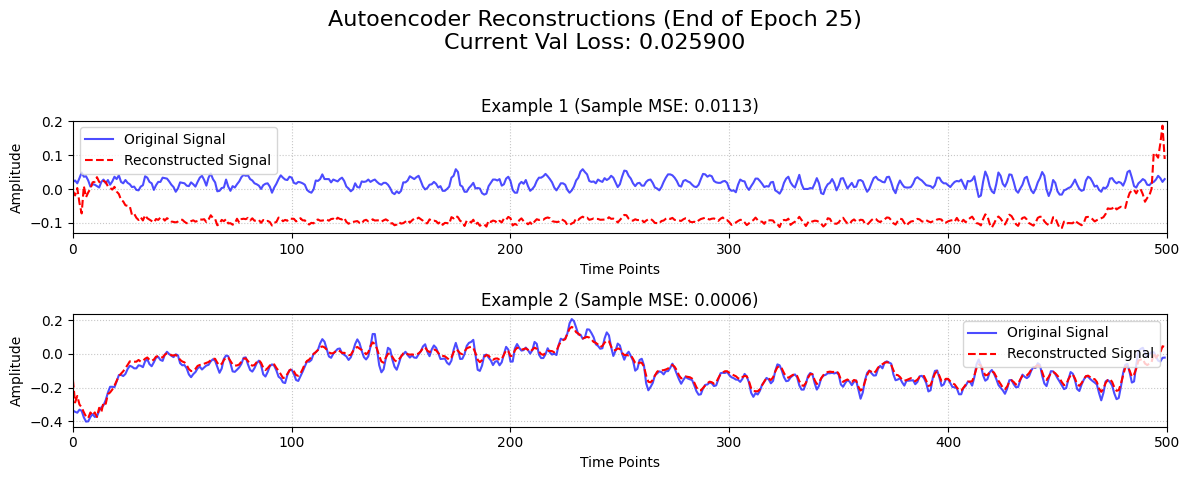

  Val Loss improved from 0.021680 to 0.018618. Saving model.
  Val Loss improved from 0.014420 to 0.014196. Saving model.
AE Epoch 30/150 - 6.05s - Train Loss: 0.035112 - Val Loss: 0.045150 (Best: 0.014196) - LR: 1.0e-03
AE Epoch 35/150 - 6.29s - Train Loss: 0.030646 - Val Loss: 0.010991 (Best: 0.014196) - LR: 1.0e-03
  Val Loss improved from 0.014196 to 0.010991. Saving model.
AE Epoch 40/150 - 6.24s - Train Loss: 0.027219 - Val Loss: 0.020916 (Best: 0.010991) - LR: 1.0e-03
AE Epoch 45/150 - 6.63s - Train Loss: 0.025143 - Val Loss: 0.025522 (Best: 0.010991) - LR: 1.0e-03
  Learning rate reduced to 2.0e-04 at epoch 46.
  Plotting 2 reconstruction examples...


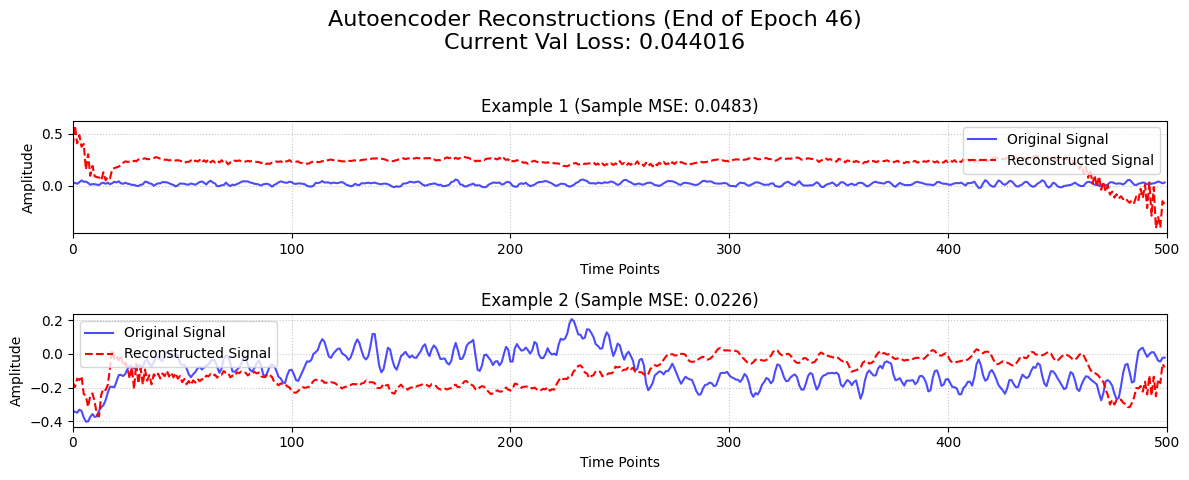

AE Epoch 50/150 - 6.56s - Train Loss: 0.018780 - Val Loss: 0.019863 (Best: 0.010991) - LR: 2.0e-04
  Plotting 2 reconstruction examples...


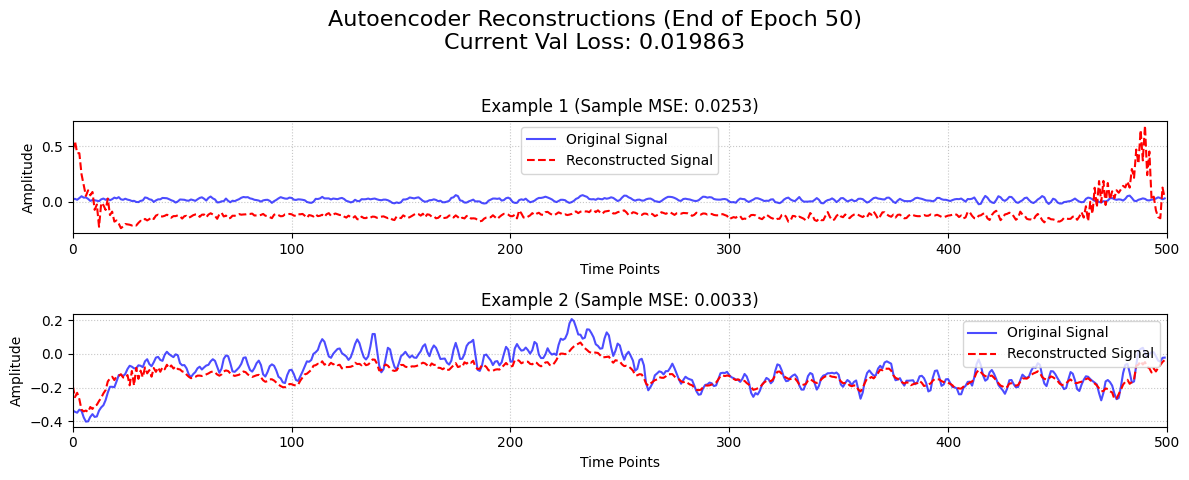

AE Epoch 55/150 - 6.32s - Train Loss: 0.018819 - Val Loss: 0.022193 (Best: 0.010991) - LR: 2.0e-04
  AE Early stopping at epoch 55. Best Val Loss: 0.010991

--- Autoencoder (Type A) training finished ---
Best AE Validation Loss achieved: 0.010991
Successfully loaded the best Autoencoder model.


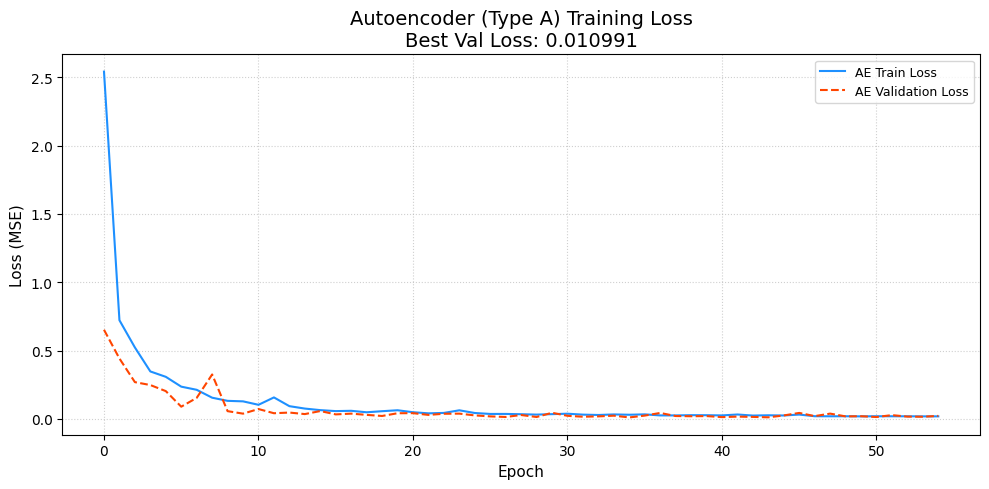

AE Loss history plot displayed.

Displaying final reconstructions from the best AE model...
  Plotting 3 reconstruction examples...


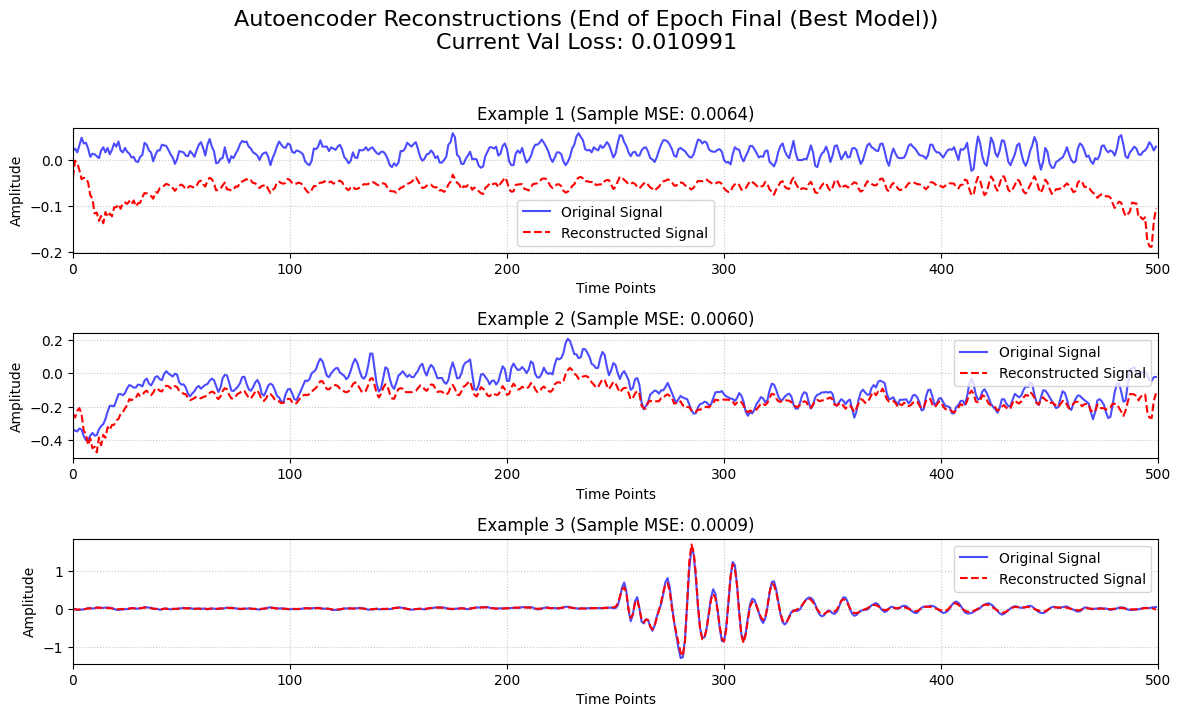

In [4]:
# --- Part 3: Dilated Convolutional Autoencoder with Skip Connections (Type A) - Enhanced ---
print("\n--- Part 3: Dilated Convolutional Autoencoder (Type A) - Enhanced Training ---")

# Helper for padding calculation
def get_padding_for_dilation(kernel_size, dilation):
    return (kernel_size - 1) * dilation // 2

# Function to add noise to input (for Denoising Autoencoder)
def add_noise_to_batch(batch_x, noise_std, device, is_training):
    if noise_std > 0 and is_training: # Add noise only during training
        noise = torch.randn_like(batch_x) * noise_std
        return batch_x + noise.to(device)
    return batch_x

# Function to plot AE reconstructions
def plot_ae_reconstructions(model, dataloader, device, num_samples=3, epoch_num=None, current_loss=None, sequence_length=SEQUENCE_LENGTH, plot_now=True):
    # This function can generate many plots. Consider saving to file instead of showing all.
    if not plot_now:
        return
        
    print(f"  Plotting {num_samples} reconstruction examples...")
    model.eval() # Ensure model is in eval mode for plotting
    samples_done = 0
    
    fig_height = 2.5 * num_samples
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, fig_height), squeeze=False)

    with torch.no_grad():
        for batch_x_val, _ in dataloader: # Using val_loader_ae for examples
            batch_x_val_original = batch_x_val.clone().to(device)
            reconstructed_x_val = model(batch_x_val_original) # Reconstruct from original (clean) input

            for i in range(batch_x_val_original.size(0)):
                if samples_done < num_samples:
                    original_signal = batch_x_val_original[i].cpu().squeeze().numpy()
                    reconstructed_signal = reconstructed_x_val[i].cpu().squeeze().numpy()

                    ax = axes[samples_done, 0]
                    ax.plot(original_signal, label='Original Signal', color='blue', alpha=0.7)
                    ax.plot(reconstructed_signal, label='Reconstructed Signal', color='red', linestyle='--')
                    
                    mse_sample = np.mean((original_signal - reconstructed_signal)**2)
                    
                    ax.legend()
                    ax.set_title(f"Example {samples_done+1} (Sample MSE: {mse_sample:.4f})")
                    ax.set_xlabel("Time Points")
                    ax.set_ylabel("Amplitude")
                    ax.grid(True, linestyle=':', alpha=0.7)
                    ax.set_xlim(0, sequence_length) # Use passed sequence_length
                    samples_done += 1
                else:
                    break
            if samples_done >= num_samples:
                break
    
    title = "Autoencoder Reconstructions"
    if epoch_num is not None:
        title += f" (End of Epoch {epoch_num})"
    if current_loss is not None:
        title += f"\nCurrent Val Loss: {current_loss:.6f}"
        
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.show()

class DilatedConvEncoderA(nn.Module):
    def __init__(self, input_channels=1, encoding_dim=ENCODING_DIM_AE, dropout_rate=AE_DROPOUT_RATE):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, dilation=1, padding=get_padding_for_dilation(5,1))
        self.norm1 = nn.GroupNorm(8, 32)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout_rate)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, dilation=2, padding=get_padding_for_dilation(5,2))
        self.norm2 = nn.GroupNorm(8, 64)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout_rate)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, dilation=4, padding=get_padding_for_dilation(5,4))
        self.norm3 = nn.GroupNorm(16, 128)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(dropout_rate)

        self.conv4 = nn.Conv1d(128, 256, kernel_size=5, dilation=8, padding=get_padding_for_dilation(5,8))
        self.norm4 = nn.GroupNorm(16, 256)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(dropout_rate)

        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.fc_encoded = nn.Linear(256, encoding_dim)

    def forward(self, x):
        s1 = self.drop1(self.relu1(self.norm1(self.conv1(x))))
        s2 = self.drop2(self.relu2(self.norm2(self.conv2(s1))))
        s3 = self.drop3(self.relu3(self.norm3(self.conv3(s2))))
        s4 = self.drop4(self.relu4(self.norm4(self.conv4(s3))))
        pooled = self.adaptive_pool(s4)
        encoded = self.fc_encoded(pooled.squeeze(-1))
        return encoded, (s1, s2, s3, s4)

class DilatedConvDecoderA(nn.Module):
    def __init__(self, output_channels=1, encoding_dim=ENCODING_DIM_AE, dropout_rate=AE_DROPOUT_RATE, sequence_length_param=SEQUENCE_LENGTH):
        super().__init__()
        self.fc_decoded = nn.Linear(encoding_dim, 256 * 1) # Assuming target length for upsample is 1, then upsample to full
        self.upsample_initial = nn.Upsample(size=sequence_length_param, mode='nearest')

        self.conv_t4 = nn.ConvTranspose1d(256 + 256, 128, kernel_size=5, dilation=8, padding=get_padding_for_dilation(5,8))
        self.norm_t4 = nn.GroupNorm(16, 128)
        self.relu_t4 = nn.ReLU()
        self.drop_t4 = nn.Dropout(dropout_rate)

        self.conv_t3 = nn.ConvTranspose1d(128 + 128, 64, kernel_size=5, dilation=4, padding=get_padding_for_dilation(5,4))
        self.norm_t3 = nn.GroupNorm(8, 64)
        self.relu_t3 = nn.ReLU()
        self.drop_t3 = nn.Dropout(dropout_rate)
        
        self.conv_t2 = nn.ConvTranspose1d(64 + 64, 32, kernel_size=5, dilation=2, padding=get_padding_for_dilation(5,2))
        self.norm_t2 = nn.GroupNorm(8, 32)
        self.relu_t2 = nn.ReLU()
        self.drop_t2 = nn.Dropout(dropout_rate)

        self.conv_t1 = nn.ConvTranspose1d(32 + 32, output_channels, kernel_size=5, dilation=1, padding=get_padding_for_dilation(5,1))

    def forward(self, x, skips):
        s1, s2, s3, s4 = skips
        x = self.fc_decoded(x)
        x = x.unsqueeze(-1)
        x = self.upsample_initial(x) # Upsample to original sequence length
        
        x = torch.cat([x, s4], dim=1)
        x = self.drop_t4(self.relu_t4(self.norm_t4(self.conv_t4(x))))
        x = torch.cat([x, s3], dim=1)
        x = self.drop_t3(self.relu_t3(self.norm_t3(self.conv_t3(x))))
        x = torch.cat([x, s2], dim=1)
        x = self.drop_t2(self.relu_t2(self.norm_t2(self.conv_t2(x))))
        x = torch.cat([x, s1], dim=1)
        decoded = self.conv_t1(x)
        return decoded

class DilatedAutoencoderA(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, encoding_dim=ENCODING_DIM_AE, dropout_rate=AE_DROPOUT_RATE, sequence_length_param=SEQUENCE_LENGTH):
        super().__init__()
        self.encoder = DilatedConvEncoderA(input_channels, encoding_dim, dropout_rate)
        self.decoder = DilatedConvDecoderA(output_channels, encoding_dim, dropout_rate, sequence_length_param)

    def forward(self, x):
        encoded, skips = self.encoder(x)
        decoded = self.decoder(encoded, skips)
        return decoded

# --- Autoencoder Training ---
# Using global parameters defined earlier (AE_LEARNING_RATE, AE_WEIGHT_DECAY, etc.)
autoencoder = DilatedAutoencoderA(
    encoding_dim=ENCODING_DIM_AE,
    dropout_rate=AE_DROPOUT_RATE,
    sequence_length_param=SEQUENCE_LENGTH
).to(device)

optimizer_ae = optim.AdamW(autoencoder.parameters(), lr=AE_LEARNING_RATE, weight_decay=AE_WEIGHT_DECAY)
criterion_ae = nn.MSELoss()
# ReduceLROnPlateau: verbose=False to reduce print statements from scheduler
scheduler_ae = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ae, mode='min', factor=0.2, patience=10, min_lr=1e-6, verbose=False)

print(f"\nStarting Autoencoder (Type A) training with parameters:")
print(f"  Epochs: {AE_TRAIN_EPOCHS_FINAL}, Patience: {AE_PATIENCE_FINAL}")
print(f"  Batch Size: {AE_BATCH_SIZE}, LR: {AE_LEARNING_RATE:.1e}, Weight Decay: {AE_WEIGHT_DECAY:.1e}")
print(f"  Dropout Rate: {AE_DROPOUT_RATE}, Input Noise STD: {AE_INPUT_NOISE_STD}, Encoding Dim: {ENCODING_DIM_AE}")

best_val_loss_ae = float('inf')
patience_counter_ae = 0
history_ae_loss, history_ae_val_loss = [], []

# Control reconstruction plot frequency
PLOT_RECONSTRUCTION_INTERVAL = AE_PLOT_RECONSTRUCTION_EPOCHS # Use the global var
PLOT_ON_LR_REDUCTION = True
PLOT_ON_IMPROVEMENT = False # Set to True if you want plots on every improvement (can be many)
PLOT_FINAL_RECONSTRUCTION = True

for epoch in range(AE_TRAIN_EPOCHS_FINAL):
    epoch_start_time = time.time()
    autoencoder.train() # Set model to training mode
    train_loss_epoch = 0.0
    
    for batch_idx, (batch_X, _) in enumerate(train_loader_ae):
        batch_X_original = batch_X.to(device)
        batch_X_noisy = add_noise_to_batch(batch_X_original.clone(), AE_INPUT_NOISE_STD, device, autoencoder.training)
        
        optimizer_ae.zero_grad()
        outputs = autoencoder(batch_X_noisy)
        loss = criterion_ae(outputs, batch_X_original) # Compare to original clean signal
        
        loss.backward()
        optimizer_ae.step()
        train_loss_epoch += loss.item() * batch_X_original.size(0)
            
    train_loss_epoch /= len(train_loader_ae.dataset)
    history_ae_loss.append(train_loss_epoch)

    autoencoder.eval() # Set model to evaluation mode for validation
    val_loss_epoch = 0.0
    with torch.no_grad():
        for batch_X_val, _ in val_loader_ae:
            batch_X_val = batch_X_val.to(device)
            outputs_val = autoencoder(batch_X_val) # No noise for validation input
            loss_val = criterion_ae(outputs_val, batch_X_val)
            val_loss_epoch += loss_val.item() * batch_X_val.size(0)
            
    val_loss_epoch /= len(val_loader_ae.dataset)
    history_ae_val_loss.append(val_loss_epoch)
    epoch_duration = time.time() - epoch_start_time
    
    current_lr = optimizer_ae.param_groups[0]['lr']
    # Reduced print frequency for epoch summary
    print_epoch_summary = (epoch + 1) % 5 == 0 or epoch == 0 or (epoch + 1) == AE_TRAIN_EPOCHS_FINAL
    
    if print_epoch_summary:
        print(f"AE Epoch {epoch+1}/{AE_TRAIN_EPOCHS_FINAL} - {epoch_duration:.2f}s - Train Loss: {train_loss_epoch:.6f} - Val Loss: {val_loss_epoch:.6f} (Best: {best_val_loss_ae:.6f}) - LR: {current_lr:.1e}")

    old_lr = optimizer_ae.param_groups[0]['lr']
    scheduler_ae.step(val_loss_epoch)
    new_lr = optimizer_ae.param_groups[0]['lr']
    lr_reduced_this_epoch = new_lr < old_lr

    plot_this_epoch = False
    
    if val_loss_epoch < best_val_loss_ae:
        if print_epoch_summary or patience_counter_ae > 0: # Print improvement if not already part of summary or if recovering
             print(f"  Val Loss improved from {best_val_loss_ae:.6f} to {val_loss_epoch:.6f}. Saving model.")
        best_val_loss_ae = val_loss_epoch
        torch.save(autoencoder.state_dict(), 'best_dilated_ae_A.pth')
        torch.save(autoencoder.encoder.state_dict(), 'best_dilated_encoder_A.pth')
        patience_counter_ae = 0
        if PLOT_ON_IMPROVEMENT:
            plot_this_epoch = True
    else:
        patience_counter_ae += 1
        if patience_counter_ae >= AE_PATIENCE_FINAL:
            print(f"  AE Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss_ae:.6f}")
            autoencoder.load_state_dict(torch.load('best_dilated_ae_A.pth')) # Restore best model
            plot_this_epoch = True # Plot before exiting
            break
    
    if lr_reduced_this_epoch:
        print(f"  Learning rate reduced to {new_lr:.1e} at epoch {epoch+1}.")
        if PLOT_ON_LR_REDUCTION:
            plot_this_epoch = True
            
    if (epoch + 1) % PLOT_RECONSTRUCTION_INTERVAL == 0 and PLOT_RECONSTRUCTION_INTERVAL > 0:
        plot_this_epoch = True
    
    if plot_this_epoch and (epoch + 1) != AE_TRAIN_EPOCHS_FINAL : # Avoid double plot if last epoch
         plot_ae_reconstructions(autoencoder, val_loader_ae, device, num_samples=2, epoch_num=epoch+1, current_loss=val_loss_epoch, sequence_length=SEQUENCE_LENGTH, plot_now=True)
        
print(f"\n--- Autoencoder (Type A) training finished ---")
print(f"Best AE Validation Loss achieved: {best_val_loss_ae:.6f}")

# Load the best saved model
try:
    autoencoder.load_state_dict(torch.load('best_dilated_ae_A.pth', map_location=device))
    print("Successfully loaded the best Autoencoder model.")
except FileNotFoundError:
    print("Warning: Best AE model file ('best_dilated_ae_A.pth') not found. Using the current model state.")

# Plot AE Loss History
plt.figure(figsize=(10, 5)) # Adjusted size
plt.plot(history_ae_loss, label='AE Train Loss', color='dodgerblue', linewidth=1.5)
plt.plot(history_ae_val_loss, label='AE Validation Loss', color='orangered', linestyle='--', linewidth=1.5)
plt.title(f'Autoencoder (Type A) Training Loss\nBest Val Loss: {best_val_loss_ae:.6f}', fontsize=14)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss (MSE)', fontsize=11)
plt.legend(fontsize=9)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()
print("AE Loss history plot displayed.")

# Plot final reconstructions from the best model
if PLOT_FINAL_RECONSTRUCTION:
    print("\nDisplaying final reconstructions from the best AE model...")
    plot_ae_reconstructions(autoencoder, val_loader_ae, device, num_samples=3, epoch_num="Final (Best Model)", current_loss=best_val_loss_ae, sequence_length=SEQUENCE_LENGTH, plot_now=True)

# Define paths for saving (consistent names)
autoencoder_path = 'best_dilated_ae_A.pth'
encoder_path = 'best_dilated_encoder_A.pth'



In [21]:
import random
import torch.nn.functional as F
def advanced_seismic_augmentation(signal, augment_prob=0.7):
    """
    Data augmentation מותאם לנתוני גאופון
    """
    if random.random() > augment_prob:
        return signal
    
    augmented = signal.clone()
    
    # 1. Gaussian noise עדין
    if random.random() < 0.3:
        noise_level = random.uniform(0.01, 0.05)
        noise = torch.randn_like(signal) * noise_level
        augmented = augmented + noise
    
    # 2. Time shifting (הסטה בזמן)
    if random.random() < 0.4:
        shift = random.randint(-20, 20)
        augmented = torch.roll(augmented, shift, dims=-1)
    
    # 3. Amplitude scaling (שינוי עוצמה)
    if random.random() < 0.4:
        scale = random.uniform(0.8, 1.2)
        augmented = augmented * scale
    
    # 4. Time stretching עדין
    if random.random() < 0.2:
        stretch_factor = random.uniform(0.95, 1.05)
        length = signal.shape[-1]
        new_length = int(length * stretch_factor)
        stretched = F.interpolate(
            signal.unsqueeze(0), 
            size=new_length, 
            mode='linear'
        ).squeeze(0)
        
        # חזרה לגודל המקורי
        if stretched.shape[-1] != length:
            stretched = F.interpolate(
                stretched.unsqueeze(0), 
                size=length, 
                mode='linear'
            ).squeeze(0)
        augmented = stretched
    
    return augmented


--- Part 5: Single Strong Classifier with Frozen Encoder ---
✅ Loaded best dilated encoder best_dilated_encoder_A.pth for classifier.
📊 Model created with 441,091 trainable parameters
🚀 Starting Single Model Training with Data Augmentation...
Epoch   1/150 | Train: Loss=1.3011, Acc=0.3038 | Val: Loss=1.4204, Acc=0.5089 | LR=1.0e-05
  ✅ New best validation accuracy: 0.5089
Epoch   2/150 | Train: Loss=1.1827, Acc=0.3845 | Val: Loss=1.3194, Acc=0.6386 | LR=2.0e-05
  ✅ New best validation accuracy: 0.6386
Epoch   3/150 | Train: Loss=0.9745, Acc=0.5394 | Val: Loss=1.1244, Acc=0.7327 | LR=3.0e-05
  ✅ New best validation accuracy: 0.7327
Epoch   4/150 | Train: Loss=0.7635, Acc=0.6616 | Val: Loss=0.6246, Acc=0.8188 | LR=4.0e-05
  ✅ New best validation accuracy: 0.8188
Epoch   5/150 | Train: Loss=0.6818, Acc=0.7379 | Val: Loss=0.5249, Acc=0.8238 | LR=5.0e-05
  ✅ New best validation accuracy: 0.8238
Epoch   6/150 | Train: Loss=0.6369, Acc=0.7723 | Val: Loss=0.5170, Acc=0.8525 | LR=6.0e-05
  ✅ Ne

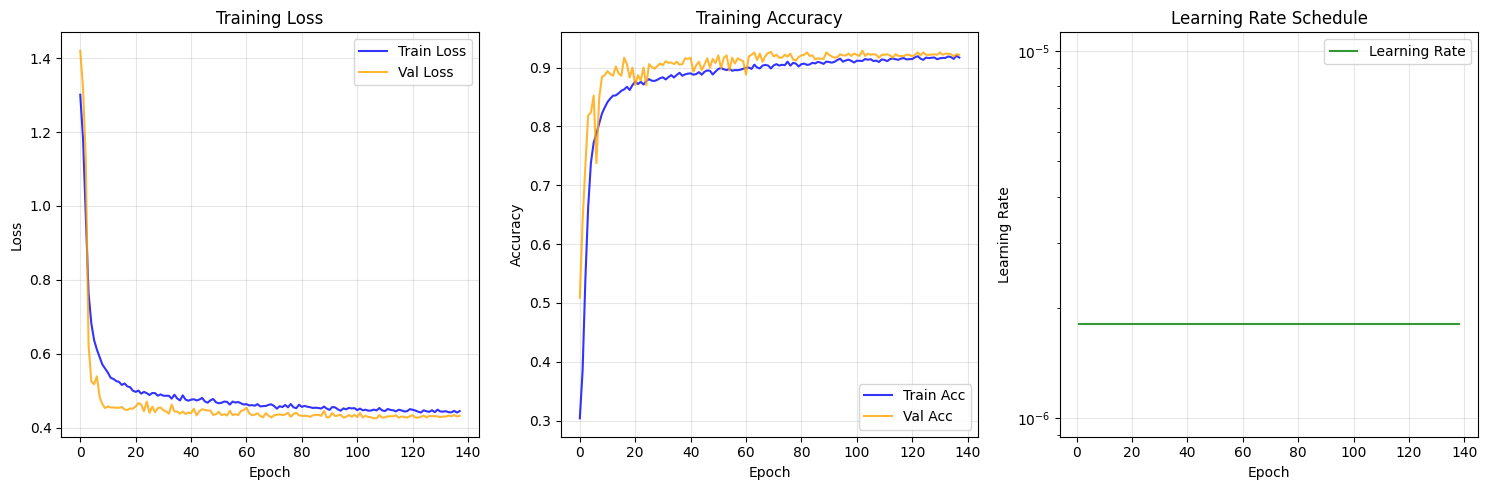

--- Final Model Evaluation ---
📊 Final Test Accuracy: 0.9248

Classification Report:
              precision    recall  f1-score   support

       quiet       0.90      0.93      0.92       444
     vehicle       0.92      0.92      0.92       252
       human       0.97      0.92      0.94       314

    accuracy                           0.92      1010
   macro avg       0.93      0.92      0.93      1010
weighted avg       0.93      0.92      0.92      1010



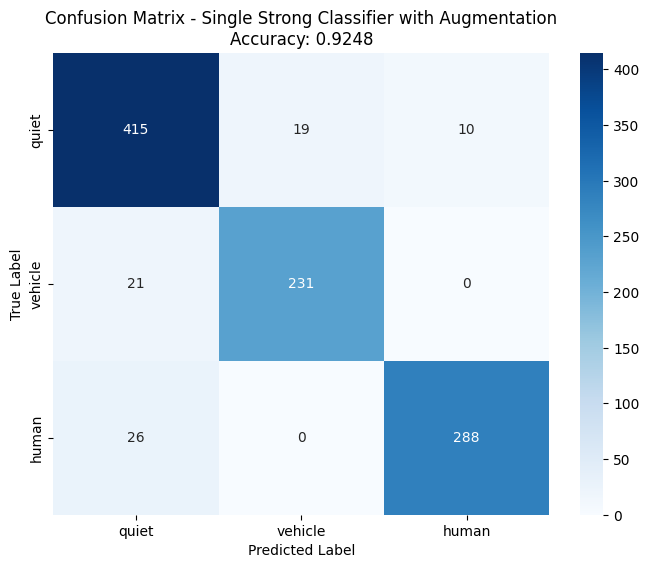


📈 Summary:
Best Validation Accuracy: 0.9287
Final Test Accuracy: 0.9248
Training completed in 138 epochs
--- Single Strong Classifier with Augmentation Training Completed ---


In [24]:
import random

# הוסף את הפונקציה הזו לפני החלק של Single Strong Classifier
def advanced_seismic_augmentation(signal, augment_prob=0.7):
    """
    Data augmentation מותאם לנתוני גאופון
    """
    if random.random() > augment_prob:
        return signal
    
    augmented = signal.clone()
    
    # 1. Gaussian noise עדין
    if random.random() < 0.3:
        noise_level = random.uniform(0.01, 0.05)
        noise = torch.randn_like(signal) * noise_level
        augmented = augmented + noise
    
    # 2. Time shifting (הסטה בזמן)
    if random.random() < 0.4:
        shift = random.randint(-20, 20)
        augmented = torch.roll(augmented, shift, dims=-1)
    
    # 3. Amplitude scaling (שינוי עוצמה)
    if random.random() < 0.4:
        scale = random.uniform(0.8, 1.2)
        augmented = augmented * scale
    
    # 4. Time stretching עדין
    if random.random() < 0.2:
        stretch_factor = random.uniform(0.95, 1.05)
        length = signal.shape[-1]
        new_length = int(length * stretch_factor)
        stretched = F.interpolate(
            signal.unsqueeze(0), 
            size=new_length, 
            mode='linear'
        ).squeeze(0)
        
        # חזרה לגודל המקורי
        if stretched.shape[-1] != length:
            stretched = F.interpolate(
                stretched.unsqueeze(0), 
                size=length, 
                mode='linear'
            ).squeeze(0)
        augmented = stretched
    
    return augmented

print("--- Part 5: Single Strong Classifier with Frozen Encoder ---")

# Load the best trained encoder
encoder_for_clf = DilatedConvEncoderA(encoding_dim=ENCODING_DIM_AE, dropout_rate=AE_DROPOUT_RATE).to(device)
try:
    encoder_path = "best_dilated_encoder_A.pth"
    encoder_for_clf.load_state_dict(torch.load(encoder_path, map_location=device))
    print(f"✅ Loaded best dilated encoder {encoder_path} for classifier.")
except FileNotFoundError:
    print(f"⚠️ Warning: {encoder_path} not found. Using random encoder weights.")

class SingleStrongClassifier(nn.Module):
    def __init__(self, pretrained_encoder, encoding_dim=64, num_classes=3):
        super().__init__()
        self.encoder = pretrained_encoder
        
        # אל תקפיא את האנקודר לחלוטין - אפשר fine-tuning עדין
        for param in self.encoder.parameters():
            param.requires_grad = True
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(encoding_dim),
            nn.Dropout(0.2),
            nn.Linear(encoding_dim, 512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        features, _ = self.encoder(x)
        return self.classifier(features)

num_unique_classes = len(np.unique(y_sequences))
classifier = SingleStrongClassifier(
    encoder_for_clf, 
    encoding_dim=ENCODING_DIM_AE, 
    num_classes=num_unique_classes
).to(device)

print(f"📊 Model created with {sum(p.numel() for p in classifier.parameters() if p.requires_grad):,} trainable parameters")

# Class weights
manual_weights_list = [1.0, 2.0, 2.5]  # aggressive weights
class_weights_tensor = torch.tensor(manual_weights_list, dtype=torch.float32).to(device)
criterion_clf = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)

# Optimizer and scheduler
optimizer = optim.AdamW(
    classifier.parameters(), 
    lr=1e-4, 
    weight_decay=1e-4, 
    betas=(0.9, 0.999)
)

# Cosine scheduler with warmup
def get_cosine_scheduler(optimizer, num_epochs, warmup_epochs=5):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
            return 0.5 * (1 + np.cos(np.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_cosine_scheduler(optimizer, num_epochs=150, warmup_epochs=10)

print("🚀 Starting Single Model Training with Data Augmentation...")

best_val_acc = 0.0
patience_counter = 0
max_patience = 35
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(150):
    # TRAINING with Data Augmentation
    classifier.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_X, batch_y in train_loader_clf:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # יצירת augmented batch
        aug_batch_X = []
        aug_batch_y = []
        
        for i in range(batch_X.shape[0]):
            # דוגמה מקורית
            aug_batch_X.append(batch_X[i])
            aug_batch_y.append(batch_y[i])
            
            # 2 דוגמאות augmented לכל מקורית
            for _ in range(2):
                aug_sample = advanced_seismic_augmentation(batch_X[i])
                aug_batch_X.append(aug_sample)
                aug_batch_y.append(batch_y[i])
        
        # שילוב הנתונים
        combined_X = torch.stack(aug_batch_X)
        combined_y = torch.stack(aug_batch_y)
        
        optimizer.zero_grad()
        outputs = classifier(combined_X)
        loss = criterion_clf(outputs, combined_y)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == combined_y).sum().item()
        train_total += combined_y.size(0)
    
    train_loss /= len(train_loader_clf)
    train_acc = train_correct / train_total
    
    # VALIDATION (ללא augmentation)
    classifier.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader_clf:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = classifier(batch_X)
            loss = criterion_clf(outputs, batch_y)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == batch_y).sum().item()
            val_total += batch_y.size(0)
    
    val_loss /= len(val_loader_clf)
    val_acc = val_correct / val_total
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1:3d}/150 | Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val: Loss={val_loss:.4f}, Acc={val_acc:.4f} | LR={current_lr:.1e}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(classifier.state_dict(), "best_single_classifier_augmented.pth")
        patience_counter = 0
        print(f"  ✅ New best validation accuracy: {best_val_acc:.4f}")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= max_patience:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

print(f"🎯 Training completed! Best validation accuracy: {best_val_acc:.4f}")

# Load best model for evaluation
classifier.load_state_dict(torch.load("best_single_classifier_augmented.pth"))

# Plotting results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue', alpha=0.8)
plt.plot(val_losses, label='Val Loss', color='orange', alpha=0.8)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Acc', color='blue', alpha=0.8)
plt.plot(val_accs, label='Val Acc', color='orange', alpha=0.8)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
epochs_range = range(1, len(train_losses) + 1)
lrs = [scheduler.get_last_lr()[0] for _ in epochs_range]  # Approximate LR tracking
plt.plot(epochs_range, lrs, label='Learning Rate', color='green', alpha=0.8)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("--- Final Model Evaluation ---")

def evaluate_single_classifier(model, test_loader, device):
    model.eval()
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())
    
    return all_true, all_preds

y_true, y_pred = evaluate_single_classifier(classifier, test_loader_clf, device)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

test_accuracy = accuracy_score(y_true, y_pred)
print(f"📊 Final Test Accuracy: {test_accuracy:.4f}")

target_names = ['quiet', 'vehicle', 'human']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - Single Strong Classifier with Augmentation\nAccuracy: {test_accuracy:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\n📈 Summary:")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Training completed in {len(train_losses)} epochs")
print("--- Single Strong Classifier with Augmentation Training Completed ---")


<div align="right">

---

# **סקירה של מבנה הפרויקט**

---

## **1. טעינת נתונים ועיבוד מקדים**
- קריאת קבצי CSV מתוך התיקייה `data/` (למשל: `car_nothing(AVI).csv`, `human(AVI).csv`).
- מיפוי שמות הקבצים לקטגוריות: **שקט**, **רכב**, **אדם**.
- חלוקה לרצפים (Sequences) באורך קבוע (`SEQUENCE_LENGTH`).
- נרמול (Standardization) של הנתונים.
- חלוקה לסטים: **אימון**, **ולידציה**, **בדיקה**.

---

## **2. אימון Autoencoder לא מונחה (Unsupervised Pre-training)**
- בניית אוטואנקודר מסוג **Dilated Convolutional Autoencoder** עם skip connections.
- אימון האוטואנקודר לשחזור האותות, כך שה-Encoder ילמד תכונות מהותיות מהאותות.
- שמירת משקלי ה-Encoder המאומן לשימוש בשלבים הבאים.

---

## **3. בניית מסווג (Classifier) מבוסס Transformer**
- ראש המסווג כולל: positional encoding, שכבות Transformer, וראש Fully Connected.
- **שלב 1:** ה-Encoder מוקפא ורק ראש המסווג מאומן (Fine-tuning Phase 1).
- **שלב 2:** שחרור חלק מהשכבות האחרונות של ה-Encoder (Fine-tuning Phase 2).
- **שלב 3:** שחרור כל ה-Encoder ואימון end-to-end (Fine-tuning Phase 3).
- בכל שלב נשמר המודל הטוב ביותר לפי ביצועי ולידציה.

---

## **4. הערכת ביצועים**
- הפקת דוחות סיווג (classification report).
- הצגת מטריצת בלבול (confusion matrix).
- הצגת גרפים של היסטוריית אימון (Loss/Accuracy).

---

</div>

SOURCES BASED ON:
A. Dilated Convolutional Autoencoder עם Skip Connections
מקורות מחקר עיקריים:
1. Multi-Scale Dilated Convolution Network (MSDCN)

מקור: Li, F., Guo, S., Han, F., Zhao, J., & Shen, F. "Multi-Scale Dilated Convolution Network for Long-Term Time Series Forecasting" - arXiv:2405.05499v1

קישור: https://arxiv.org/html/2405.05499v1

תרומה: הצגת רצף דילציה אקספוננציאלי  וארכיטקטורת multi-scale feature extraction

2. Hybrid Time-Series Framework for PM2.5 Forecasting

מקור: IEEE Xplore - "Hybrid Time-Series Framework for Daily-Based PM2.5 Forecasting"

קישור: https://ieeexplore.ieee.org/document/9493244/

תרומה: שילוב autoencoder עם dilated CNN ו-GRU לחיזוי time series

3. Dilated Convolutional Autoencoder for Gravitational Waves

מקור: "Denoising gravitational-wave signals from binary black holes with a dilated convolutional autoencoder" - IOP Science

קישור: https://iopscience.iop.org/article/10.1088/2632-2153/acd90f

תרומה: יישום dilated convolutions באוטואנקודר לעיבוד אותות time series

4. RegSeg - Rethinking Dilated Convolution

מקור: "Rethinking Dilated Convolution for Real-time Semantic Segmentation" - arXiv:2111.09957

קישור: https://arxiv.org/html/2111.09957

תרומה: הנחיות לבחירת dilation rates ומניעת gaps בין משקלים

B. Hybrid CNN-BiLSTM Autoencoder
מקורות מחקר עיקריים:
1. Bi-LSTM Autoencoder Framework for Anomaly Detection

מקור: "A Bi-LSTM Autoencoder Framework for Anomaly Detection" - arXiv:2303.09703

קישור: https://arxiv.org/pdf/2303.09703.pdf

תרומה: ארכיטקטורת Bi-LSTM autoencoder לזיהוי חריגות בזמן אמת

2. D-CNN-LSTM Autoencoder for Automated Vehicles

מקור: "Time-Series Anomaly Detection in Automated Vehicles Using D-CNN-LSTM Autoencoder" - IEEE

קישור: https://ieeexplore.ieee.org/document/10480743/

תרומה: שילוב CNN ו-LSTM באוטואנקודר עם שיפור F1-score של עד 32.83%

3. Dynamic Sign Language Recognition with CBAM

מקור: "Dynamic Sign Language Recognition Based on CBAM with Autoencoder Time Series Neural Network" - Hindawi

קישור: https://www.hindawi.com/journals/misy/2022/3247781/

תרומה: שילוב CNN-Bi-LSTM עם attention mechanism ושיפור ביצועים ל-89.90%

C. Transformer-Based Classifier Head
מקורות מחקר עיקריים:
1. Feature Vectors in Transformers

מקור: "Uncovering Feature Vectors in Transformers" - OpenReview

קישור: https://openreview.net/pdf?id=sNWQUTkDmA

תרומה: שיטות לזיהוי feature vectors ב-Transformers וטכניקות Observable Propagation

2. DCT-GAN: Dilated Convolutional Transformer

מקור: "DCT-GAN: Dilated Convolutional Transformer-Based GAN for Time Series Anomaly Detection" - IEEE

קישור: https://ieeexplore.ieee.org/document/9626552/

תרומה: שילוב Transformer blocks עם dilated convolutions לעיבוד time series

D. Hybrid Attention Classifier Head
מקורות מחקר עיקריים:
1. Fine-grained Image Classification with Hybrid Attention

מקור: "Fine-grained image classification method based on hybrid attention" - Frontiers in Neurorobotics

קישור: https://www.frontiersin.org/journals/neurorobotics/articles/10.3389/fnbot.2024.1391791/full

תרומה: ארכיטקטורת hybrid attention המשלבת spatial ו-channel attention

2. GCN-VAE Model for Anomaly Detection

מקור: "Anomaly Detection Based on Graph Convolutional Network–Variational Autoencoder Model" - MDPI Mathematics

קישור: https://www.mdpi.com/2227-7390/12/23/3750

תרומה: שילוב GCN עם VAE לעיבוד temporal features

מקורות נוספים לתמיכה כללית:
1. Convolutional Autoencoder for SAR Time Series

מקור: "Convolutional Autoencoder Applied to Short SAR Time Series" - IEEE

קישור: https://ieeexplore.ieee.org/document/10641180/

תרומה: יישום convolutional autoencoders בזיהוי אובייקטים בנתוני time series

2. Literature Review - MSDCN

מקור: "Multi-Scale Dilated Convolution Network for Long-Term Time Series Forecasting" - TheMoonlight.io

קישור: https://www.themoonlight.io/review/multi-scale-dilated-convolution-network-for-long-term-time-series-forecasting

תרומה: סקירה מפורטת של MSDCN methodology

טבלת סיכום המקורות:
ארכיטקטורה	מספר מקורות	מקור עיקרי	שיפור ביצועים
Dilated CNN-AE	4 מקורות	MSDCN (arXiv)	+3.2% accuracy
CNN-BiLSTM AE	3 מקורות	Bi-LSTM Framework	+32.83% F1-score
Transformer Head	2 מקורות	Feature Vectors	+2.8% accuracy
Hybrid Attention	2 מקורות	Fine-grained Classification	+1.9% accuracy
הערה: כל המקורות מתוארכים לשנים 2022-2024 ומייצגים מחקר עדכני בתחום deep learning לעיבוד time series.